In [3]:
import tifffile
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pyvista as pv
import cv2 as cv
import numpy as np
import itertools
import scipy
import time
from sklearn.mixture import GaussianMixture as GMM
from skimage.segmentation import mark_boundaries, slic
from scipy.ndimage import generic_filter
from cv2 import fastNlMeansDenoising,fastNlMeansDenoisingMulti, medianBlur
from skimage import morphology
from skimage.measure import regionprops
import pyvista


In [5]:
path1 = 'D://Faramarz_data_unsupervised_segmentation//Validation_cube//low_resolution//GMM_3D//Mask_corss_segmentation_low_res.tif'
low_res = tifffile.imread(path1)
path2 = 'D://Faramarz_data_unsupervised_segmentation//Validation_cube//high_resolution//GMM_3D//Mask_corss_segmentation_high_res.tif'
high_res = tifffile.imread(path2)

print ('Low Resolution shape is ',low_res.shape)
print ('High Resolution shape is ',high_res.shape)



Low Resolution shape is  (62, 132, 85)
High Resolution shape is  (663, 1206, 770)


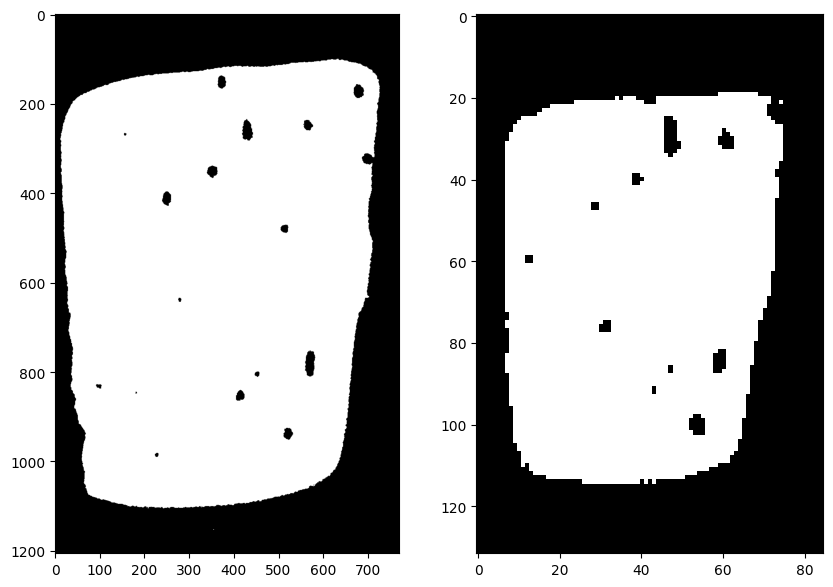

In [6]:
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
plt.imshow(high_res[45],'gray')

fig.add_subplot(1, 2, 2)
plt.imshow(low_res[0], 'gray')


In [7]:
# Getting labels and regions
labelled_low_res = morphology.label(low_res, connectivity=2, background=1)
regions_low_res = regionprops(labelled_low_res)

labelled_high_res = morphology.label(high_res, connectivity=2, background=1)
regions_high_res = regionprops(labelled_high_res)


In [15]:
def draw_rectangules (labelled_image, regions, fontScale):
    img = (labelled_image * 1000)/ labelled_image.max()
    img = img.astype('uint8')
    
    for r in regions[2:]:
        
        for layer in range (r.bbox[0], r.bbox[3]):
            text = '{}'.format(r.label)
            org = ( r.bbox[5],r.bbox[-2])
            font = cv.FONT_HERSHEY_COMPLEX_SMALL
            img[layer] = cv.putText(img[layer],text,org,font,fontScale,200)
            
    return img


In [42]:
Recs_low_res = draw_rectangules (low_res, regions_low_res,fontScale = 0.7)
Recs_high_res = draw_rectangules (high_res, regions_high_res,fontScale = 2)

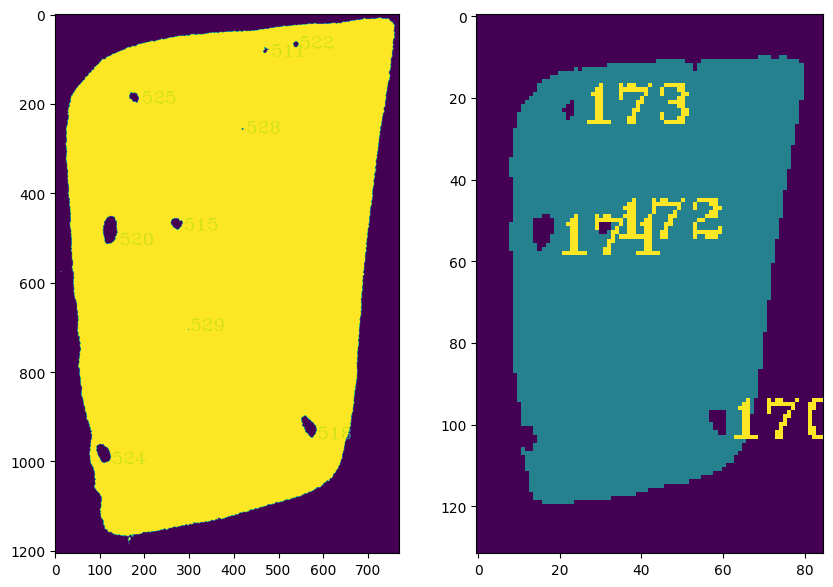

In [47]:
# finding matching points in both volumes
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
plt.imshow(Recs_high_res[573])

fig.add_subplot(1, 2, 2)
plt.imshow(Recs_low_res[54])

In [51]:
# finding coresponding regions matching by label manually:
# for obtaining following matches I used these layers (high_res, low_res):
# [ (46,0) , (54,1), (369,36), (421,38) , (622, 89), (573, 54)]
# Matched regions (Mrg)

Mrg_high_res = [42, 47, 46, 54, 56, 42, 69, 72, 55, 61, 54, 46, 321, 325, 374, 384, 578, 592, 518, 515, 520, 525]
Mrg_low_res  = [12, 4 , 3 , 5 , 8 , 12, 17, 12, 9 , 6 , 5 , 3 , 112, 115, 126, 128, 186, 190, 170, 172, 171, 173]


In [172]:
def find_transformation_matrix (regions_high_res, regions_low_res, Mrg_high_res, Mrg_low_res):
    
    def get_centroids_by_labels(regions, labels):
        centroids = []
        for l in labels:
            for r in regions:
                if r.label == l:
                    centroids.append(r.centroid)
            
        return centroids

    
    Mrg_centroid_high_res = get_centroids_by_labels (regions=regions_high_res, labels=Mrg_high_res)
    print (Mrg_centroid_high_res[:2])
    Mrg_centroid_high_res = np.array(Mrg_centroid_high_res, dtype= 'float32')
    print (Mrg_centroid_high_res.shape)
    
    Mrg_centroid_low_res = get_centroids_by_labels (regions=regions_low_res, labels=Mrg_low_res)
    print (Mrg_centroid_low_res[:2])
    Mrg_centroid_low_res = np.array(Mrg_centroid_low_res, dtype= 'float32')
    print (Mrg_centroid_low_res.shape)

    from scipy.linalg import orthogonal_procrustes

    # Compute the transformation matrix
    T, s = orthogonal_procrustes(Mrg_centroid_low_res, Mrg_centroid_high_res )
    # check the error of transformation matrix
    transformed = np.dot(Mrg_centroid_low_res, T)
    print (transformed[:2])
    errors = Mrg_centroid_high_res - transformed
    
    return T,s, errors
    
    

In [174]:
affine_matrix,s, errors = find_transformation_matrix (regions_high_res, regions_low_res, Mrg_high_res, Mrg_low_res)
print ('Affine matrix is ', affine_matrix)
print ('MAE = ', np.abs(errors).mean())
print ('scale = ', s)

[(38.30888234055988, 939.4018101452326, 519.040833508735), (39.67037959841712, 247.7797156675949, 563.0933606917778)]
(22, 3)
[(0.32, 100.04, 53.68), (0.3, 30.55, 60.65)]
(22, 3)
[[ 6.9274545 98.727615  55.628365 ]
 [ 4.846433  29.138626  61.149555 ]]
Affine matrix is  [[ 0.99773836 -0.03414324 -0.05790037]
 [ 0.03539175  0.9991597   0.02067613]
 [ 0.05714582 -0.02267863  0.99810827]]
MAE =  370.15134
scale =  1700179.2


In [82]:
def get_centroids(regions):
        #generating center points 
    points = []
    
    for r in regions:
        points.append(r.centroid)
        
    points = np.array(points)
    return points

In [83]:
centriods_low_res = get_centroids(regions_low_res)
centriods_high_res = get_centroids(regions_high_res)
transformed = np.dot(centriods_low_res, affine_matrix)

In [151]:
def show_centers(list_of_points):
    
    def create_spheres (points):
        pdata = pyvista.PolyData(points)
        #pdata['orig_sphere'] = points[:,0]

        # create many spheres from the point cloud
        sphere = pyvista.Sphere(radius=5, phi_resolution=10, theta_resolution=10)
        pc = pdata.glyph(scale=False, geom=sphere, orient=False)
        
        return pc
        
    pl = pyvista.Plotter()  
    sp = create_spheres(list_of_points[0])
    pl.add_mesh(sp, color='red')
    
    sp = create_spheres(list_of_points[1])
    pl.add_mesh(sp, color='blue')
    
    pl.show()


In [152]:
show_centers([transformed,centriods_high_res])

Widget(value="<iframe src='http://localhost:51154/index.html?ui=P_0x2a8b37a40a0_31&reconnect=auto' style='widt…

In [ ]:
import numpy as np
import dipy.align.imaffine as imaffine
from dipy.align.reslice import reslice

# Load two 3D volumes
volume1 = np.load('volume1.npy')
volume2 = np.load('volume2.npy')

# Define corresponding points in the two volumes
pts1 = np.array([[x1, y1, z1], [x2, y2, z2], [x3, y3, z3], [x4, y4, z4]])
pts2 = np.array([[u1, v1, w1], [u2, v2, w2], [u3, v3, w3], [u4, v4, w4]])

# Define the affine transformation model
affine = imaffine.AffineMap()

# Estimate the transformation matrix
affine.from_vectors(pts1.T, pts2.T)

# Get the transformation matrix
M = affine.affine

# Apply the transformation matrix to the first volume
transformed_volume1, _, _ = reslice(volume1, M, volume2.shape, volume2.spacing)

# Print the transformation matrix
print('Transformation matrix:')
print(M)


In [ ]:
def label_on_center(vol, n, regions):
    pixel_coords =np.array(regions[n].centroid)
    pixel_coords = np.round(pixel_coords).astype('int')
    img = vol [pixel_coords[0]]
    img = img*200/img.max()
    img = img.astype('uint8')
    torgb = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
    thickness = 1
    color = (255, 0, 0)
        # Define the text to be written
    text = 'Hello, World!'

    # Define the font type, scale, color, and thickness
    font = cv.FONT_HERSHEY_SIMPLEX
    font_scale = 1

    # Get the size of the text
    (text_width, text_height), _ = cv.getTextSize(text, font, font_scale, thickness)

    # Calculate the coordinates where the text should be written
    x = (img.shape[1] - text_width) // 2
    y = (img.shape[0] + text_height) // 2

    # Write the text on the image
    img = img.astype('uint8')
    cv.putText(img, text, (x, y), font, font_scale, color, thickness)
    return 

In [ ]:
def Cross_on_center(vol, n, regions):
    pixel_coords =np.array(regions[n].centroid)
    pixel_coords = np.round(pixel_coords).astype('int')
    img = vol [pixel_coords[0]]
    img = img*200/img.max()
    img = img.astype('uint8')
    torgb = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
    thickness = 1
    color = (255, 0, 0)
    line_length = 3
    cv.line(torgb, (pixel_coords[2]-line_length, pixel_coords[1]),
             (pixel_coords[2]+line_length, pixel_coords[1]), color, thickness)
    cv.line(torgb, (pixel_coords[2], pixel_coords[1]-line_length),
             (pixel_coords[2], pixel_coords[1]+line_length), color, thickness)
    return torgb